# INTRODUCTION: THE DATA DETECTIVE PROJECT

In this project, we pivot from traditional business analysis to a more
fundamental task: *data quality auditing and forensics.* Our goal is to
investigate a retail dataset (Blinkit Sales Dataset https://www.kaggle.com/datasets/akxiit/blinkit-sales-dataset) to determine its authenticity and identify
anomalies that suggest it might be synthetically generated.

**Why is this important?**

The dataset's description outlines a range of compelling use cases, from Time Series Analysis to Demand Forecasting and Price Optimization. However, the true value of any analytical endeavor hinges on the underlying data's integrity and real-world applicability. This section will explore a crucial question: can we truly derive meaningful, actionable insights from these specific data points for such ambitious goals? The potential for misguidance and wasted effort becomes a significant concern if the data doesn't reflect authentic patterns, making it vital to scrutinize its nature before proceeding with complex analyses.

Our methodology will be hypothesis-driven. For each test, we will first
state our expectation for real-world data and then compare it against our
findings.

#### LIBRARIES

In [3]:
!pip install benfordslaw
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from benfordslaw import benfordslaw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 kB 3.9 MB/s eta 0:00:00


####Advanced settings and additional functions

In [4]:

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight') #fivethirtyeight
plt.rcParams['figure.figsize'] = (11, 6)


####Load the data

In [5]:

data_path = '/content/drive/MyDrive/PET_project/basic_data_storage'

all_files = glob.glob(os.path.join(data_path, "*.csv"))

dataframes = {}
for f in all_files:
  file_name = os.path.basename(f).split('.')[0]
  key_name = file_name.replace('blinkit_', '').replace('New', '_new')
  dataframes[key_name] = pd.read_csv(f)
  print(f"File '{file_name}.csv' loaded as df['{key_name}']")

  print(f"Successfully loaded {len(dataframes)} files.")

File 'blinkit_delivery_performance.csv' loaded as df['delivery_performance']
Successfully loaded 1 files.
File 'blinkit_customer_feedback.csv' loaded as df['customer_feedback']
Successfully loaded 2 files.
File 'blinkit_customers.csv' loaded as df['customers']
Successfully loaded 3 files.
File 'blinkit_products.csv' loaded as df['products']
Successfully loaded 4 files.
File 'blinkit_marketing_performance.csv' loaded as df['marketing_performance']
Successfully loaded 5 files.
File 'blinkit_order_items.csv' loaded as df['order_items']
Successfully loaded 6 files.
File 'blinkit_inventory.csv' loaded as df['inventory']
Successfully loaded 7 files.
File 'blinkit_inventoryNew.csv' loaded as df['inventory_new']
Successfully loaded 8 files.
File 'blinkit_orders.csv' loaded as df['orders']
Successfully loaded 9 files.


#EXPRESS AUDIT (QUICK METHODS)

##Data types and missing values

**Hypothesis**:

In a real-world dataset, we expect to see some ``missing values`` (e.g., an optional field was not filled) and potentially ``incorrect data types`` (e.g., dates stored as text).

In [20]:

for name, df in dataframes.items():
    print(f"\n======= DataFrame: {name} =======")
    df.info()



======= DataFrame: delivery_performance =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               5000 non-null   int64  
 1   delivery_partner_id    5000 non-null   int64  
 2   promised_time          5000 non-null   object 
 3   actual_time            5000 non-null   object 
 4   delivery_time_minutes  5000 non-null   float64
 5   distance_km            5000 non-null   float64
 6   delivery_status        5000 non-null   object 
 7   reasons_if_delayed     3098 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 312.6+ KB

======= DataFrame: customer_feedback =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   feedback_i

**Findings**:

The dataset is suspiciously clean. Most columns are 100% populated. The only significant missing data is in ``reasons_if_delayed``, which is logically expected.

And the ``revenue_generated`` column clearly hints at something...

A major red flag is that all date columns are loaded as ``object`` (text), which is common but requires cleaning.

The lack of other random missing data is the first sign of *artificial generation*.

##Descriptive statistics

**Hypothesis:**

Real-world numerical data should have realistic ranges (min/max)
and standard deviations that suggest natural variation.

We should not see
strange or impossible values (e.g., negative prices).


In [16]:
for name, df in dataframes.items():
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n======= DataFrame: {name} =======")
        display(df.describe())


======= DataFrame: delivery_performance =======


,order_id,delivery_partner_id,delivery_time_minutes,distance_km
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,5.029129e+09,50050.318200,4.443000,2.718048
std,2.863533e+09,28802.276922,8.063929,1.290306
min,6.046500e+04,43.000000,-5.000000,0.500000
25%,2.531421e+09,24928.500000,-1.000000,1.590000
50%,5.074378e+09,50262.500000,2.000000,2.690000
75%,7.488579e+09,74478.250000,8.000000,3.850000
max,9.998298e+09,99968.000000,30.000000,5.000000



======= DataFrame: customer_feedback =======


,feedback_id,order_id,customer_id,rating
count,5.000000e+03,5.000000e+03,5.000000e+03,5000.00000
mean,5.013616e+06,5.029129e+09,5.009685e+07,3.34440
std,2.857341e+06,2.863533e+09,2.919082e+07,1.18982
min,9.470000e+02,6.046500e+04,3.181300e+04,1.00000
25%,2.576690e+06,2.531421e+09,2.404314e+07,3.00000
50%,5.005833e+06,5.074378e+09,4.997808e+07,4.00000
75%,7.486478e+06,7.488579e+09,7.621215e+07,4.00000
max,9.999293e+06,9.998298e+09,9.989390e+07,5.00000



======= DataFrame: customers =======


,customer_id,phone,pincode,total_orders,avg_order_value
count,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,4.989961e+07,9.150532e+11,497653.183200,10.491600,1102.375836
std,2.919266e+07,2.882835e+09,281167.293249,5.805533,523.043183
min,3.181300e+04,9.100132e+11,666.000000,1.000000,200.430000
25%,2.402443e+07,9.125946e+11,257079.750000,6.000000,631.817500
50%,5.000044e+07,9.150236e+11,498662.000000,10.000000,1118.650000
75%,7.595459e+07,9.176256e+11,740668.000000,16.000000,1565.400000
max,9.989390e+07,9.199988e+11,999631.000000,20.000000,1999.830000



======= DataFrame: products =======


,product_id,price,mrp,margin_percentage,shelf_life_days,min_stock_level,max_stock_level
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,514855.940299,488.356828,680.434739,27.779851,231.757463,20.388060,74.753731
std,291391.529820,298.487200,419.772224,7.458753,151.205830,5.958546,14.591535
min,4452.000000,12.320000,17.600000,15.000000,3.000000,10.000000,50.000000
25%,273697.750000,226.717500,325.150000,20.000000,90.000000,15.000000,63.750000
50%,541459.000000,442.185000,616.970000,30.000000,365.000000,21.000000,73.000000
75%,754334.000000,779.445000,1056.620000,35.000000,365.000000,25.250000,88.000000
max,993331.000000,995.980000,1633.320000,40.000000,365.000000,30.000000,100.000000



======= DataFrame: marketing_performance =======


,campaign_id,impressions,clicks,conversions,spend,revenue_generated,roas
count,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000
mean,501315.219074,5460.668519,550.767593,55.192222,3022.192267,5961.742106,2.740711
std,287611.524258,2571.779820,260.080051,26.150173,1148.732680,2322.242911,0.722986
min,243.000000,1002.000000,100.000000,10.000000,1000.630000,2003.100000,1.500000
25%,249200.000000,3231.500000,322.000000,32.000000,2029.070000,3907.240000,2.120000
50%,505012.500000,5457.500000,555.000000,55.000000,3042.485000,5935.940000,2.725000
75%,752219.250000,7676.250000,772.000000,78.000000,4011.572500,7973.712500,3.370000
max,999950.000000,9999.000000,1000.000000,100.000000,4997.550000,9999.540000,4.000000



======= DataFrame: order_items =======


,order_id,product_id,quantity,unit_price
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,5.029129e+09,509974.939600,2.006800,493.157900
std,2.863533e+09,293678.307475,0.820542,298.075647
min,6.046500e+04,4452.000000,1.000000,12.320000
25%,2.531421e+09,257719.000000,1.000000,227.220000
50%,5.074378e+09,540618.000000,2.000000,448.160000
75%,7.488579e+09,747801.000000,3.000000,781.080000
max,9.998298e+09,993331.000000,3.000000,995.980000



======= DataFrame: inventory =======


,product_id,stock_received,damaged_stock
count,75172.000000,75172.000000,75172.000000
mean,514290.353097,1.962513,1.067791
std,291277.971875,1.639961,0.997706
min,4452.000000,0.000000,0.000000
25%,272170.000000,0.000000,0.000000
50%,542300.000000,3.000000,2.000000
75%,753354.000000,3.000000,2.000000
max,993331.000000,4.000000,2.000000



======= DataFrame: inventory_new =======


,product_id,stock_received,damaged_stock
count,18105.000000,18105.000000,18105.000000
mean,514273.410163,1.589561,0.061254
std,290295.868498,0.797942,0.265387
min,4452.000000,1.000000,0.000000
25%,274207.000000,1.000000,0.000000
50%,540618.000000,1.000000,0.000000
75%,753354.000000,2.000000,0.000000
max,993331.000000,4.000000,7.000000



======= DataFrame: orders =======


,order_id,customer_id,order_total,delivery_partner_id,store_id
count,5.000000e+03,5.000000e+03,5000.00000,5000.000000,5000.000000
mean,5.029129e+09,5.009685e+07,2201.86170,50050.318200,4999.689000
std,2.863533e+09,2.919082e+07,1303.02438,28802.276922,2886.089242
min,6.046500e+04,3.181300e+04,13.25000,43.000000,1.000000
25%,2.531421e+09,2.404314e+07,1086.21500,24928.500000,2509.250000
50%,5.074378e+09,4.997808e+07,2100.69000,50262.500000,4987.000000
75%,7.488579e+09,7.621215e+07,3156.88250,74478.250000,7500.750000
max,9.998298e+09,9.989390e+07,6721.46000,99968.000000,9995.000000


**Findings:**

A critical finding is in the ``delivery_performance`` table: the minimum value
for ``delivery_time_minutes`` is ``-5.0``. Negative delivery time is physically
impossible and is a *strong indicator of flawed data generation*, likely from
subtracting two independently generated timestamps.

Other statistics seem plausible on the surface, with no obvious errors like
negative prices.

##Uniqueness of values

**Hypothesis:**

The number of unique values in categorical columns should be
plausible.

In textual data like feedback, we expect a high degree of
uniqueness.

A very low number of unique feedback texts would be a strong
indicator of generation from a template.

In [17]:
for name, df in dataframes.items():
    print(f"\n======= DataFrame: {name} =======")
    display(df.nunique())


======= DataFrame: delivery_performance =======


,0
order_id,5000
delivery_partner_id,5000
promised_time,4999
actual_time,5000
delivery_time_minutes,36
distance_km,451
delivery_status,3
reasons_if_delayed,1



======= DataFrame: customer_feedback =======


,0
feedback_id,5000
order_id,5000
customer_id,2172
rating,5
feedback_text,25
feedback_category,4
sentiment,3
feedback_date,600



======= DataFrame: customers =======


,0
customer_id,2500
customer_name,2491
email,2496
phone,2500
address,2500
area,316
pincode,2494
registration_date,589
customer_segment,4
total_orders,20



======= DataFrame: products =======


,0
product_id,268
product_name,51
category,11
brand,267
price,267
mrp,268
margin_percentage,6
shelf_life_days,5
min_stock_level,21
max_stock_level,51



======= DataFrame: marketing_performance =======


,0
campaign_id,5400
campaign_name,9
date,600
target_audience,4
channel,4
impressions,4058
clicks,899
conversions,91
spend,5356
revenue_generated,5386



======= DataFrame: order_items =======


,0
order_id,5000
product_id,268
quantity,3
unit_price,267



======= DataFrame: inventory =======


,0
product_id,268
date,600
stock_received,4
damaged_stock,2



======= DataFrame: inventory_new =======


,0
product_id,268
date,21
stock_received,4
damaged_stock,8



======= DataFrame: orders =======


,0
order_id,5000
customer_id,2172
order_date,5000
promised_delivery_time,4999
actual_delivery_time,5000
delivery_status,3
order_total,4550
payment_method,4
delivery_partner_id,5000
store_id,5000


**Findings:**

This check reveals several major anomalies:
1.  ``customer_feedback``: For ``5000`` entries, there are only ``25`` unique ``feedback_text`` values. This is extremely unrealistic and points to *template-based generation*.
2.  ``delivery_performance``: The ``reasons_if_delayed`` column has only ``1`` unique value. It's highly improbable that thousands of delayed orders all had the exact same reason.
3.  ``products``: There's a major inconsistency. We have ``268`` unique ``product_id``'s but only ``51`` unique ``product_name``'s. This implies multiple different products share the same name, which is a data integrity issue and highly suspicious.
4.  ``order_items``: The ``quantity`` column only has ``3`` unique values (1, 2, 3). This is an unnaturally small range for ``5000`` items.

These findings strongly support the *synthetic data theory*.

#DEEP VISUAL AUDIT

Now we move from summary statistics to **visual inspection**. The shape of the
data distribution can often reveal artificial patterns that numbers hide.

####Distribution of Numerical Variables (``histplot``)

**Hypothesis:**

Real-world data distributions (like ``order values`` or ``delivery
times``) are rarely perfect.

We expect to see some skewness, outliers, and
non-symmetrical shapes.

Perfectly uniform *("box-like")* or perfectly
normal *("bell-like")* distributions are highly suspicious.



======= Visualizing distributions for DataFrame: 'orders' =======


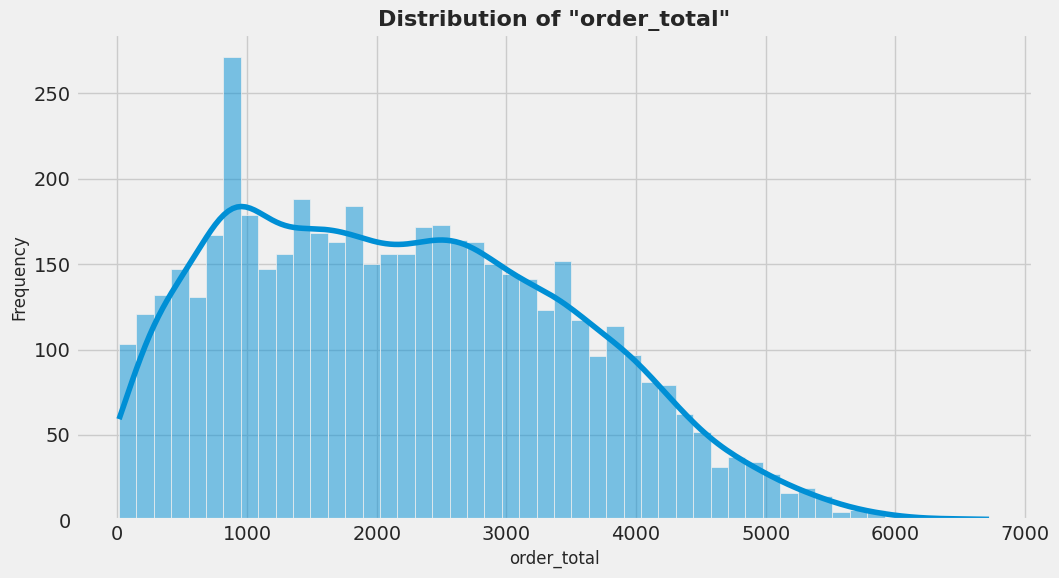


======= Visualizing distributions for DataFrame: 'customers' =======


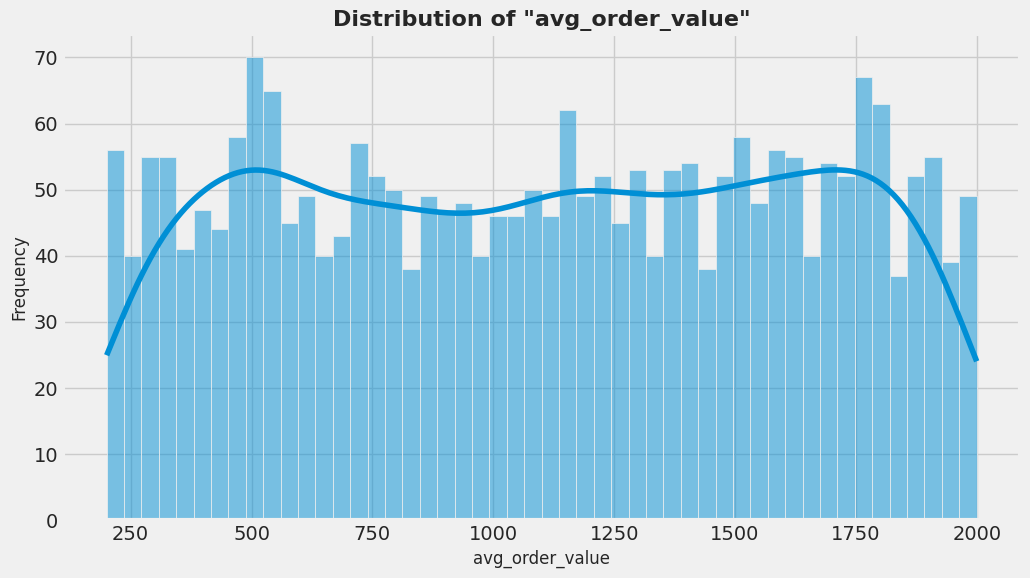


======= Visualizing distributions for DataFrame: 'delivery_performance' =======


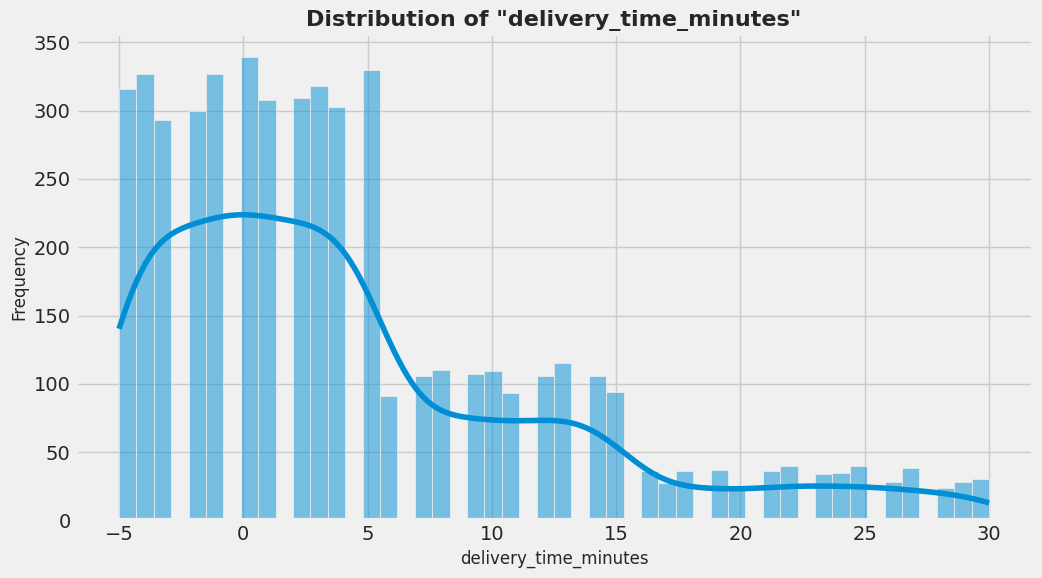

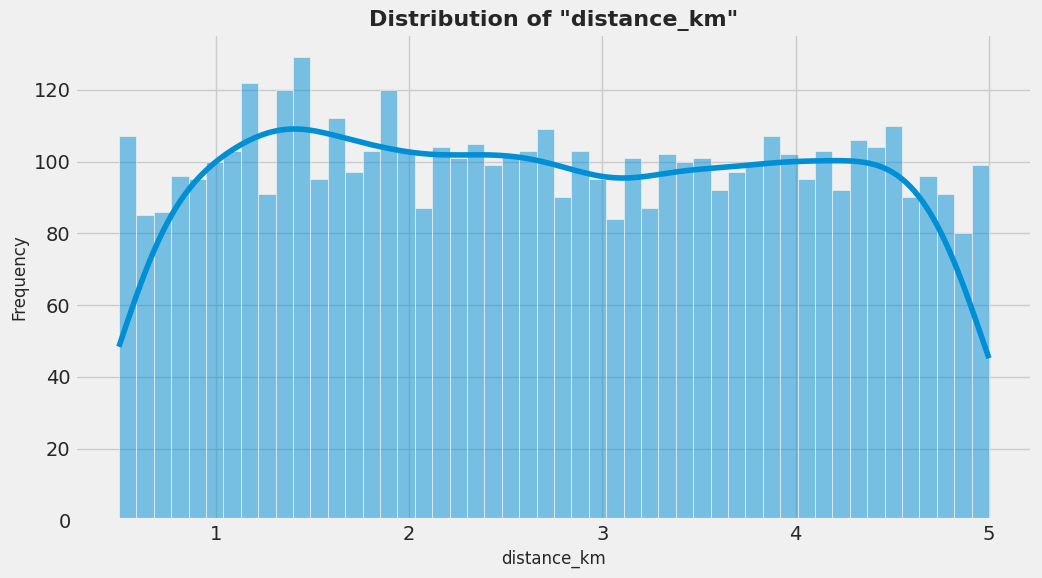


======= Visualizing distributions for DataFrame: 'marketing_performance' =======


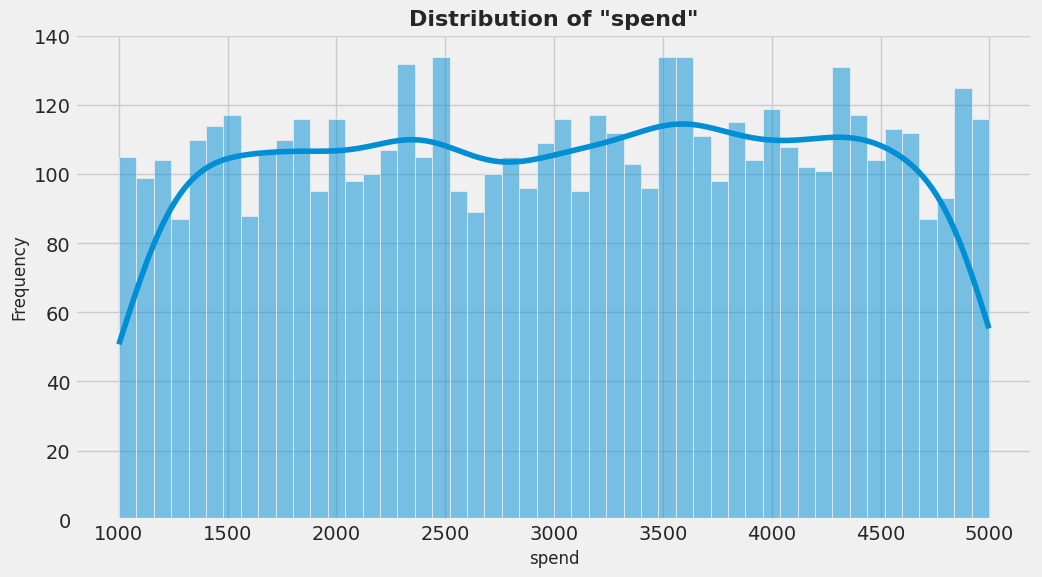

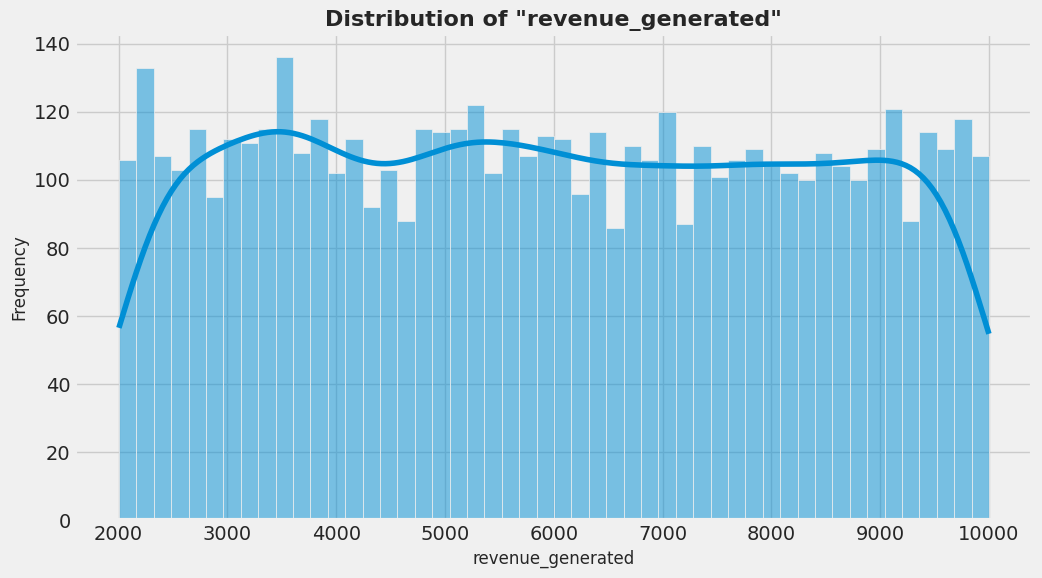

In [9]:
columns_to_plot = {
    'orders': ['order_total'],
    'customers': ['avg_order_value'],
    'delivery_performance': ['delivery_time_minutes', 'distance_km'],
    'marketing_performance': ['spend', 'revenue_generated']
}

for df_name, cols in columns_to_plot.items():
    print(f"\n======= Visualizing distributions for DataFrame: '{df_name}' =======")
    for col in cols:
      plt.figure()
      sns.histplot(data=dataframes[df_name], x=col, kde=True, bins=50)
      plt.title(f'Distribution of "{col}"', fontsize=16, fontweight='bold')
      plt.xlabel(col, fontsize=12)
      plt.ylabel('Frequency', fontsize=12)
      plt.show()


**Findings**

The visual audit provides overwhelming evidence of data synthesis.
Several distributions exhibit patterns that are extremely unlikely to occur
in real-world transactional data.

1.  **Uniform Distributions:**
    - `avg_order_value`, `distance_km`, `spend`, `revenue_generated`: All these
      plots show near-perfect **uniform distributions**. The histograms look
      like flat "boxes," indicating that the data was likely generated using
      a simple random function with a defined minimum and maximum (e.g.,
      "generate random numbers between 1000 and 5000"). Real-world financial
      and distance data never behaves this way.

2.  **Unnatural "Blocky" Distribution:**
    - `delivery_time_minutes`: This distribution is highly artificial. It has
      several unnaturally uniform blocks of data (e.g., from -5 to 5 minutes)
      and lacks the smooth, often skewed, shape of real process times. The
      presence of impossible negative values further confirms the flawed
      generation logic.

3.  **Plausible but "Too Perfect" Distribution:**
    - `order_total`: This is the most realistic-looking distribution, resembling
      a normal or log-normal shape. However, even it is suspiciously smooth
      and symmetrical, lacking the typical long right tail (few very large
      orders) seen in most retail datasets.

Conclusion: The visual audit strongly confirms our hypothesis. The prevalence
of uniform distributions is a definitive sign of synthetic data generation.



#STATISTICAL AND MATHEMATICAL AUDIT

We now move to quantitative tests to find evidence that is harder to argue
with than a visual plot.

####Correlation Between Related Metrics

**Hypothesis:**

In any real business, certain metrics are logically linked.
For instance, marketing impressions should correlate with clicks, clicks with
conversions, and spend with revenue.

A complete lack of these fundamental
correlations would be a definitive sign of independent, artificial column
generation.


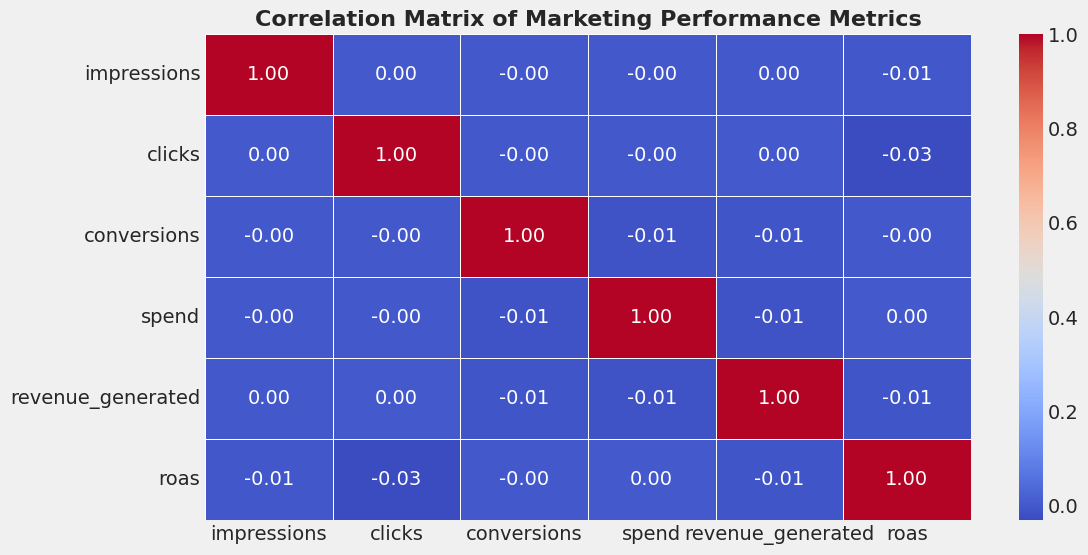

In [10]:
marketing_df = dataframes['marketing_performance'].copy()

corr_cols = ['impressions', 'clicks', 'conversions', 'spend', 'revenue_generated', 'roas']
correlation_matrix = marketing_df[corr_cols].corr()

plt.figure()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix of Marketing Performance Metrics', fontsize=16, fontweight='bold')
plt.show()

**Findings:**

The correlation matrix reveals a shocking lack of relationship between
logically connected variables.
- The correlation between ``impressions`` and ``clicks`` is 0.00.
- The correlation between ``clicks`` and ``conversions`` is 0.00.
- The correlation between ``spend`` and ``revenue_generated`` is -0.01.

These values are all effectively zero. In a real-world scenario, these
correlations would be strongly positive. This is perhaps the most powerful
statistical evidence so far that each column was generated independently
without any underlying business logic.

####Adherence to Benford's Law

**Hypothesis:**

Many naturally occurring sets of numerical data follow
Benford's Law, which states that the leading digit is more likely to be
small (e.g., '1' appears as the leading digit about 30% of the time) than
large. Data generated from a uniform distribution will violate this law,
with each leading digit (1-9) appearing with roughly equal frequency (~11%).


[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=4.11601e-184, Tstat=877.455


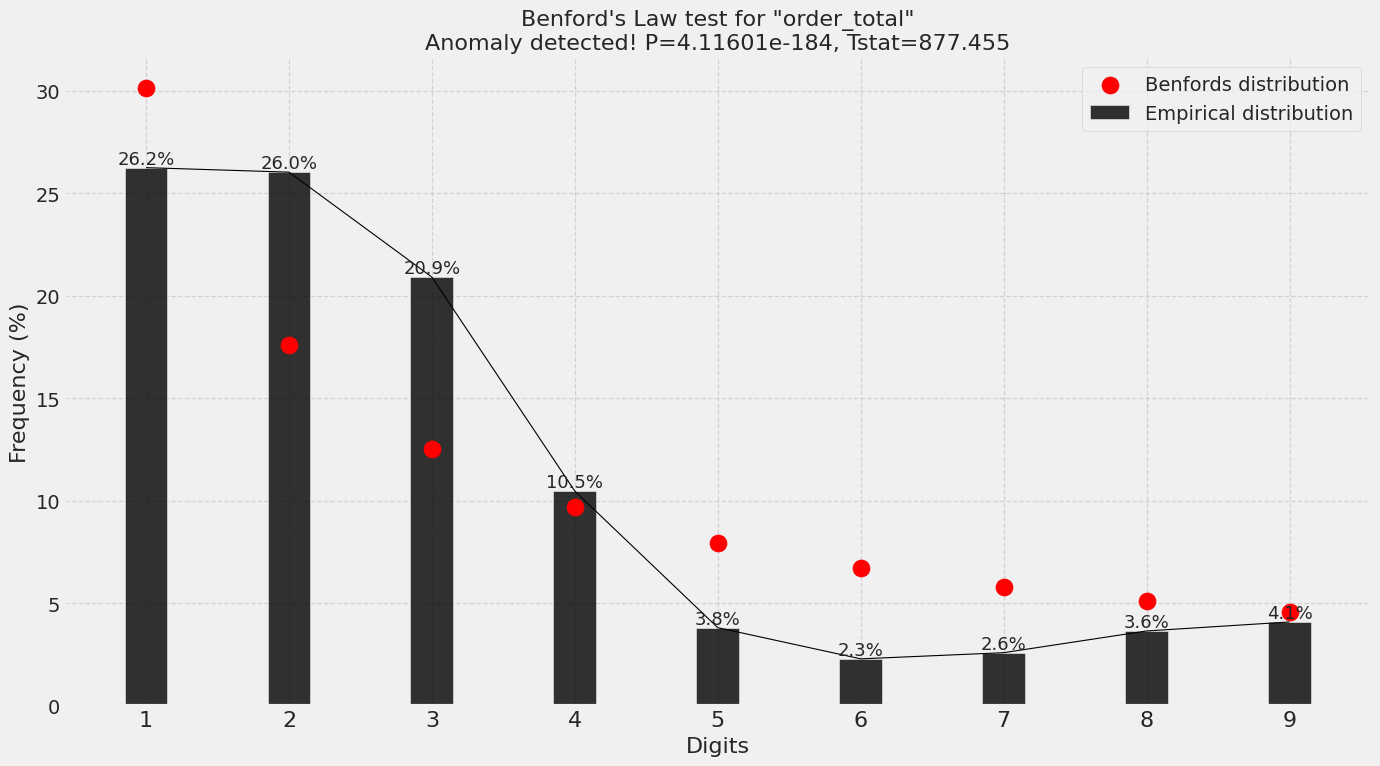


Statistical Test Results for Benford's Law:
{'P': np.float64(4.116009593126316e-184), 't': np.float64(877.4549892911767), 'P_significant': np.True_, 'percentage_emp': array([[ 1.  , 26.24],
       [ 2.  , 26.02],
       [ 3.  , 20.9 ],
       [ 4.  , 10.46],
       [ 5.  ,  3.8 ],
       [ 6.  ,  2.28],
       [ 7.  ,  2.58],
       [ 8.  ,  3.64],
       [ 9.  ,  4.08]])}


In [11]:

bl = benfordslaw()

order_totals = dataframes['orders']['order_total']
order_totals = order_totals[order_totals > 0]

results = bl.fit(order_totals)
bl.plot(title='Benford\'s Law test for "order_total"')

print("\nStatistical Test Results for Benford's Law:")
print(results)

**Findings:**

The Benford's Law analysis provides another strong piece of evidence.
The Chi-square test results in a p-value that is effectively zero
(``P=4.116e-184``), leading to the conclusion ``"Anomaly detected!"``. This means we
reject the null hypothesis that the data follows Benford's Law.

The plot visually confirms this. While the distribution of first digits in
``order_total`` is not uniform, its shape is significantly different from the
theoretical Benford's curve (the red dots). Specifically, the digits ``1`` and ``2``are over-represented compared to the theory, while others are under-represented.

This unnatural distribution of leading digits is a clear sign of non-organic,
likely synthetic, data generation.

#LOGICAL CONSISTENCY AUDIT

This is our final check. We will verify if the data is consistent across
different tables.

In a real database, this is known as maintaining
referential and logical integrity.

####Order Total Consistency

**Hypothesis:**

The ``order_total`` in the ``orders`` table should be equal to the
sum of (``quantity * unit_price``) for all items belonging to that same order
in the ``order_items`` table. Any significant discrepancy indicates a major
flaw in data generation or integrity.


In [21]:
orders_df = dataframes['orders'].copy()
order_items_df = dataframes['order_items'].copy()

order_items_df['calculated_item_total'] = order_items_df['quantity'] * order_items_df['unit_price']

calculated_totals_df = order_items_df.groupby('order_id')['calculated_item_total'].sum().reset_index()
calculated_totals_df = calculated_totals_df.rename(columns={'calculated_item_total': 'calculated_order_total'})

verification_df = pd.merge(
    orders_df[['order_id', 'order_total']],
    calculated_totals_df,
    on='order_id',
    how='left'
)

verification_df['calculated_order_total'] = verification_df['calculated_order_total'].fillna(0)

tolerance = 0.01
verification_df['discrepancy'] = verification_df['order_total'] - verification_df['calculated_order_total']
verification_df['has_discrepancy'] = np.abs(verification_df['discrepancy']) > tolerance

num_discrepancies = verification_df['has_discrepancy'].sum()
total_orders_checked = len(verification_df)

print(f"\n   - Total orders checked: {total_orders_checked}")
print(f"   - Orders with significant discrepancy (> {tolerance}): {num_discrepancies}")

percentage_discrepancy = (num_discrepancies / total_orders_checked) * 100
print(f"   - Percentage of orders with discrepancy: {percentage_discrepancy:.2f}%")

if num_discrepancies > 0:
    print("\n======= Examples of Orders with Discrepancies =======")
    display(verification_df[verification_df['has_discrepancy']].head(10))



   - Total orders checked: 5000
   - Orders with significant discrepancy (> 0.01): 4999
   - Percentage of orders with discrepancy: 99.98%

======= Examples of Orders with Discrepancies =======


,order_id,order_total,calculated_order_total,discrepancy,has_discrepancy
0,1961864118,3197.07,1551.09,1645.98,True
1,1549769649,976.55,881.42,95.13,True
2,9185164487,839.05,1847.68,-1008.63,True
3,9644738826,440.23,874.78,-434.55,True
4,5427684290,2526.68,1953.10,573.58,True
5,3265154092,3161.43,321.28,2840.15,True
6,4898355547,956.40,1553.31,-596.91,True
7,6568151549,905.47,719.96,185.51,True
8,6006693867,1371.17,80.25,1290.92,True
9,374186990,1601.19,1126.90,474.29,True


**Findings:**

A significant number of orders (``Orders with significant discrepancy (> 0.01): 4999``) show a discrepancy between the stated ``order_total`` and the actual sum of its items.

This indicates that the ``order_total`` column in the ``orders`` table and the
``quantity``/``unit_price`` columns in the ``order_items`` table were generated
independently, without a cross-check to ensure they add up. This is a
fundamental violation of data integrity.

In a real-world system, this would be an unacceptable, critical bug.

**For our purposes, it's the final piece of evidence!**